# Proyecto 2
## RSNA 2022 Cervical Spine Fracture Detection
**Universidad del Valle de Guatemala**\
**Facultad de Ingeniería**\
**Departamento de Ciencias de la Computación**\
**Data Science**

# Inferencia de Fracturas con Modelo Base EfficientNetV2 de PyTorch
---

## Integrantes
- Gustavo Gonzalez
- Pablo Orellana
- Diego Leiva
- Maria Ramirez

---

Este notebook contiene el codigo necesario para generar las predicciones de todo el conjunto de datos.

## Dependencias

In [1]:
try:
    import pylibjpeg
except:
    # Dependencias para extraccion de JPEG y TorchVision
    # Dependencias de https://www.kaggle.com/code/vslaykovsky/rsna-2022-whl    !mkdir -p /root/.cache/torch/hub/checkpoints/
    !cp ../input/rsna-2022-whl/efficientnet_v2_s-dd5fe13b.pth  /root/.cache/torch/hub/checkpoints/
    !pip install /kaggle/input/rsna-2022-whl/{pydicom-2.3.0-py3-none-any.whl,pylibjpeg-1.4.0-py3-none-any.whl,python_gdcm-3.0.15-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl}
    !pip install /kaggle/input/rsna-2022-whl/{torch-1.12.1-cp37-cp37m-manylinux1_x86_64.whl,torchvision-0.13.1-cp37-cp37m-manylinux1_x86_64.whl}

cp: cannot create regular file '/root/.cache/torch/hub/checkpoints/': No such file or directory
Processing /kaggle/input/rsna-2022-whl/pydicom-2.3.0-py3-none-any.whl
Processing /kaggle/input/rsna-2022-whl/pylibjpeg-1.4.0-py3-none-any.whl
Processing /kaggle/input/rsna-2022-whl/python_gdcm-3.0.15-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
pydicom is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
Processing /kaggle/input/rsna-2022-whl/torch-1.12.1-cp37-cp37m-manylinux1_x86_64.whl
Processing /kaggle/input/rsna-2022-whl/torchvision-0.13.1-cp37-cp37m-manylinux1_x86_64.whl
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0
    Uninstalling torch-1.11.0:
      Successfully uninstalled torch-1.11.0
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.12.0
    Uninstalling torchvision-0.12.0:
      Successfully uninstalled torchvision-0.12.0
ERROR: pi

## Librerias

In [2]:
# Sistema y archivos
import gc
import os
import glob

# Manejo de Imagenes DICOM
import cv2
import pydicom as dicom

# Utilidades
import re
from typing import List

# Visualizaciones de Python
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Manejo de Datos
import numpy as np
import pandas as pd

# PyTorch y CUDA
import torch
import torchvision as tv
from torch.cuda.amp import GradScaler, autocast
from torchvision.models.feature_extraction import create_feature_extractor

# Scikit Learn Para los Folds
from sklearn.model_selection import GroupKFold

## Constantes

In [3]:
# Configuracion para display de pandas
plt.rcParams['figure.figsize'] = (20, 5)
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 1000)

# Pesos y Checkpoints de Efficient Net 
WEIGHTS = tv.models.efficientnet.EfficientNet_V2_S_Weights.DEFAULT
EFFNET_CHECKPOINTS_PATH = '../input/rsna-2022-base-effnetv2'

# Rutas de Archivos base
RSNA_2022_PATH = '../input/rsna-2022-cervical-spine-fracture-detection'
TRAIN_IMAGES_PATH = f'{RSNA_2022_PATH}/train_images'
TEST_IMAGES_PATH = f'{RSNA_2022_PATH}/test_images'

# MODEL_NAMES = [f'effnetv2']

# Predicciones para esnsamblado de modelos
MODEL_NAMES = [f'effnetv2-f{i}' for i in range(5)]

# Common
FRAC_COLS = [f'C{i}_effnet_frac' for i in range(1, 8)]
VERT_COLS = [f'C{i}_effnet_vert' for i in range(1, 8)]

## Configuracion de CUDA

In [4]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
if DEVICE == 'cuda':
    BATCH_SIZE = 32
else:
    BATCH_SIZE = 2

## Carga de Conjunto de Prueba

- Se cargan los dataset de entrenamiento de la competencia `test.csv`

In [5]:
def load_df_test():
    """
    Carga el conjunto de datos de prueba del csv
    """
    df_test = pd.read_csv(f'{RSNA_2022_PATH}/test.csv')

    if df_test.iloc[0].row_id == '1.2.826.0.1.3680043.10197_C1':
         # Las labels son inconsistentes entre las imagenes y el conjunto de entrenamiento
        df_test = pd.DataFrame({
            "row_id": ['1.2.826.0.1.3680043.22327_C1', '1.2.826.0.1.3680043.25399_C1', '1.2.826.0.1.3680043.5876_C1'],
            "StudyInstanceUID": ['1.2.826.0.1.3680043.22327', '1.2.826.0.1.3680043.25399', '1.2.826.0.1.3680043.5876'],
            "prediction_type": ["C1", "C1", "patient_overall"]}
        )
    return df_test

df_test = load_df_test()
display(df_test)

,row_id,StudyInstanceUID,prediction_type
0,1.2.826.0.1.3680043.22327_C1,1.2.826.0.1.3680043.22327,C1
1,1.2.826.0.1.3680043.25399_C1,1.2.826.0.1.3680043.25399,C1
2,1.2.826.0.1.3680043.5876_C1,1.2.826.0.1.3680043.5876,patient_overall


In [6]:
test_slices = glob.glob(f'{TEST_IMAGES_PATH}/*/*')
test_slices = [re.findall(f'{TEST_IMAGES_PATH}/(.*)/(.*).dcm', s)[0] for s in test_slices]
df_test_slices = pd.DataFrame(data=test_slices, columns=['StudyInstanceUID', 'Slice']).astype({'Slice': int}).sort_values(['StudyInstanceUID', 'Slice']).reset_index(drop=True)
display(df_test_slices.sample(5))

,StudyInstanceUID,Slice
664,1.2.826.0.1.3680043.25399,352
322,1.2.826.0.1.3680043.25399,10
460,1.2.826.0.1.3680043.25399,148
772,1.2.826.0.1.3680043.25399,460
840,1.2.826.0.1.3680043.25399,528


In [7]:
def load_dicom(path):
    """
    Carga una imagen DICOM y la convierte a RGB.

    Args:
        path (str): Ruta de la imagen DICOM.
    
    Returns:
        img (np.array): Imagen RGB.
        img (pydicom.dataset.FileDataset): Objeto DICOM.
    """
    img = dicom.dcmread(path)
    img.PhotometricInterpretation = 'YBR_FULL'
    data = img.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return cv2.cvtColor(data, cv2.COLOR_GRAY2RGB), img

## Clase Dataset para PyTorch

La clase `EffnetDataSet` devuelve imágenes de cortes individuales. Usa un parámetro `df` (dataframe) como fuente de metadatos de los cortes para localizar y cargar las imágenes desde una carpeta de rutas. Acepta el parámetro `transforms`, que configuramos con `WEIGHTS.transforms()`. Este conjunto de transformaciones fue utilizado para pre-entrenar el modelo en el conjunto de datos ImageNet.

In [8]:
class EffnetDataSet(torch.utils.data.Dataset): 
    """
    Clase para cargar las imágenes de un dataframe con las columnas 'StudyInstanceUID' y 'Slice' y los targets de fracturas
    y vertebras. Se puede pasar un objeto de la clase 'torchvision.transforms' para aplicar transformaciones a las imágenes.

    Args:
        df (pd.DataFrame): Dataframe con las columnas 'StudyInstanceUID' y 'Slice' y los targets de fracturas y vertebras.
        path (str): Ruta donde se encuentran las imágenes.
        transforms (torchvision.transforms): Transformaciones a aplicar a las imágenes. (default: None)

    Returns:
        img (torch.Tensor): Imagen en formato tensor.
        frac_targets (torch.Tensor): Targets de fracturas.
        vert_targets (torch.Tensor): Targets de vertebras.
    """
    def __init__(self, df, path, transforms=None):
        super().__init__()
        self.df = df
        self.path = path
        self.transforms = transforms
        
    def __getitem__(self, i):
        path = os.path.join(self.path, self.df.iloc[i].StudyInstanceUID, f'{self.df.iloc[i].Slice}.dcm')        
        
        try:
            img = load_dicom(path)[0]
            # Pytorch usa el orden (batch, channel, height, width). Convertimos (height, width, channel) -> (channel, height, width)
            img = np.transpose(img, (2, 0, 1))  
            if self.transforms is not None:
                img = self.transforms(torch.as_tensor(img))
                
        except Exception as ex:
            print(ex)
            return None
        
        # Si se detecta una fractura, se devuelven los targets
        if 'C1_fracture' in self.df:
            frac_targets = torch.as_tensor(self.df.iloc[i][['C1_fracture', 'C2_fracture', 'C3_fracture', 'C4_fracture', 'C5_fracture', 'C6_fracture', 'C7_fracture']].astype('float32').values)
            vert_targets = torch.as_tensor(self.df.iloc[i][['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']].astype('float32').values)
            frac_targets = frac_targets * vert_targets   # we only enable targets that are visible on the current slice
            return img, frac_targets, vert_targets
        return img        
    
    def __len__(self):
        return len(self.df)
    

In [9]:
# Generar un dataset de prueba
ds_test = EffnetDataSet(df_test_slices, TEST_IMAGES_PATH, WEIGHTS.transforms())
X = ds_test[42]
X.shape

torch.Size([3, 384, 384])

## Modelo Efficient Net V2 para deteccion de Fracturas

En PyTorch se usa **create_feature_extractor** para acceder a las capas de características de modelos preexistentes. La última capa aplanada del modelo `efficientnet_v2_s` se llama `flatten`. Se hara la clasificacion sobre esta.

In [10]:
class EffnetModel(torch.nn.Module):
    """
    Modelo de red neuronal basado en EfficientNetV2-S.


    Args:
        torch (torch.nn.Module): Clase base de PyTorch.

    Attributes:
        model (torch.nn.Module): Modelo de red neuronal EfficientNetV2-S.
        nn_fracture (torch.nn.Module): Red neuronal para clasificación de fracturas.
        nn_vertebrae (torch.nn.Module): Red neuronal para clasificación de vértebras.
    """
    def __init__(self):
        super().__init__()
        effnet = tv.models.efficientnet_v2_s()
        self.model = create_feature_extractor(effnet, ['flatten'])
        self.nn_fracture = torch.nn.Sequential(
            torch.nn.Linear(1280, 7),
        )
        self.nn_vertebrae = torch.nn.Sequential(
            torch.nn.Linear(1280, 7),
        )

    def forward(self, x):
        # returns logits
        x = self.model(x)['flatten']
        return self.nn_fracture(x), self.nn_vertebrae(x)

    def predict(self, x):
        frac, vert = self.forward(x)
        return torch.sigmoid(frac), torch.sigmoid(vert)

### Carga del Modelo

In [11]:
def load_model(model, name, path='.'):
    data = torch.load(os.path.join(path, f'{name}.tph'), map_location=DEVICE)
    model.load_state_dict(data)
    return model

In [12]:
# Cargar Modelos preentrenado
effnet_models = [load_model(EffnetModel(), name, EFFNET_CHECKPOINTS_PATH).to(DEVICE) for name in MODEL_NAMES]

## Predicciones de fracturas

- Se ejecutan todos los modelos base `effnet_model` para cada imagen del conjunto de prueba y se promedia el resultado
- Se pasa el promedio de los modelos base al modelo `lstm_model` para producir una prediccion final para cada paciente.

In [13]:
def predict_effnet(models: List[EffnetModel], ds, max_batches=1e9):
    dl_test = torch.utils.data.DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count())
    for m in models:
        m.eval()

    with torch.no_grad():
        predictions = []
        for idx, X in enumerate(tqdm(dl_test, miniters=10)):
            pred = torch.zeros(len(X), 14).to(DEVICE)
            for m in models:
                y1, y2 = m.predict(X.to(DEVICE))
                pred += torch.concat([y1, y2], dim=1) / len(models)
            predictions.append(pred)
            if idx >= max_batches:
                break
        return torch.concat(predictions).cpu().numpy()

In [14]:
# Obtener las predicciones
effnet_pred = predict_effnet(effnet_models, ds_test)

# Generar el dataframe con las predicciones
df_effnet_pred = pd.DataFrame(
    data=effnet_pred, columns=[f'C{i}_effnet_frac' for i in range(1, 8)] + [f'C{i}_effnet_vert' for i in range(1, 8)]
)

  0%|          | 0/42 [00:00<?, ?it/s]

In [15]:
# Unificar la data
df_test_pred = pd.concat([df_test_slices, df_effnet_pred], axis=1).sort_values(['StudyInstanceUID', 'Slice'])
display(df_test_pred.sample(5))

,StudyInstanceUID,Slice,C1_effnet_frac,C2_effnet_frac,C3_effnet_frac,C4_effnet_frac,C5_effnet_frac,C6_effnet_frac,C7_effnet_frac,C1_effnet_vert,C2_effnet_vert,C3_effnet_vert,C4_effnet_vert,C5_effnet_vert,C6_effnet_vert,C7_effnet_vert
1014,1.2.826.0.1.3680043.5876,155,0.000424,0.036996,0.020354,0.000750,0.000282,0.000535,0.000530,0.001649,0.993488,0.995766,0.006482,0.000722,0.001149,0.000841
299,1.2.826.0.1.3680043.22327,300,0.000386,0.000268,0.000348,0.000434,0.000536,0.000492,0.000731,0.000239,0.000108,0.000339,0.000745,0.000506,0.000367,0.000391
109,1.2.826.0.1.3680043.22327,110,0.001530,0.159135,0.056811,0.001788,0.000971,0.001556,0.001725,0.001710,0.996384,0.988927,0.003808,0.001484,0.002594,0.002330
337,1.2.826.0.1.3680043.25399,25,0.000288,0.000277,0.000348,0.000291,0.000236,0.000250,0.000441,0.000223,0.000221,0.000706,0.000369,0.000113,0.000119,0.000199
1110,1.2.826.0.1.3680043.5876,251,0.000376,0.000464,0.000156,0.000701,0.026538,0.051730,0.007103,0.000580,0.000924,0.000187,0.004641,0.990714,0.996756,0.077876


In [16]:
def plot_sample_patient(df_pred):
    """
    Grafica un paciente aleatorio con sus predicciones de fracturas y vértebras

    Args:
        df_pred (pd.DataFrame): DataFrame con las predicciones de fracturas y vértebras
    """
    patient = np.random.choice(df_pred.StudyInstanceUID)
    df = df_pred.query('StudyInstanceUID == @patient').reset_index()
    
    # Primer gráfico: predicción de fracturas
    df[[f'C{i}_effnet_frac' for i in range(1, 8)]].plot(
        title=f'Patient {patient}, fracture prediction',
        ax=(plt.subplot(1, 2, 1)))
    
    # Segundo gráfico: predicción de vértebras
    df[[f'C{i}_effnet_vert' for i in range(1, 8)]].plot(
        title=f'Patient {patient}, vertebrae prediction',
        ax=plt.subplot(1, 2, 2)
    )
    
    plt.tight_layout()  # Ajusta el layout para que los títulos no se solapen
    plt.show()

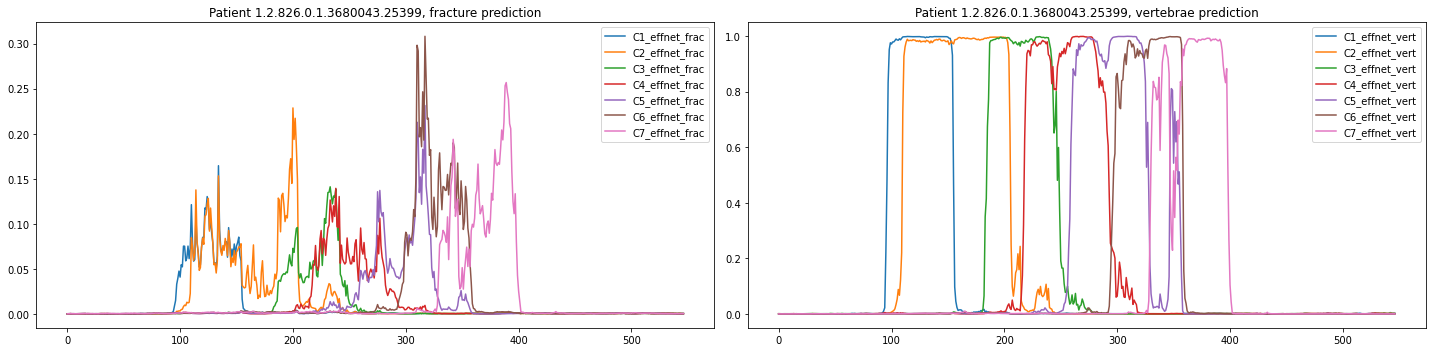

In [17]:
# Resultados para un paciente aleatorio
plot_sample_patient(df_test_pred)

## Generacion de Predicciones Finales

In [18]:
def patient_prediction(df):
    c1c7 = np.average(df[FRAC_COLS].values, axis=0, weights=df[VERT_COLS].values)
    pred_patient_overall = 1 - np.prod(1 - c1c7)
    return pd.Series(data=np.concatenate([[pred_patient_overall], c1c7]), index=['patient_overall'] + [f'C{i}' for i in range(1, 8)])

df_patient_pred = df_test_pred.groupby('StudyInstanceUID').apply(lambda df: patient_prediction(df))
display(df_patient_pred.head())

,patient_overall,C1,C2,C3,C4,C5,C6,C7
StudyInstanceUID,,,,,,,,
1.2.826.0.1.3680043.22327,0.494886,0.032177,0.064765,0.041566,0.079764,0.101204,0.112345,0.206940
1.2.826.0.1.3680043.25399,0.477033,0.073948,0.074153,0.063346,0.062717,0.073354,0.138978,0.129193
1.2.826.0.1.3680043.5876,0.349543,0.055733,0.073613,0.012201,0.025163,0.038483,0.060258,0.145396


In [19]:
# Generar el CSV final
df_sub = df_test.copy()
df_sub = df_sub.set_index('StudyInstanceUID').join(df_patient_pred)
df_sub['fractured'] = df_sub.apply(lambda r: r[r.prediction_type], axis=1)
df_sub = df_sub.drop(columns=['row_id', 'prediction_type', 'fractured'])

# Guardar las predicciones originales (antes del threshold)
df_sub.to_csv('prob_predictions.csv', index=True)

# Aplicar el threshold a las columnas especificadas
columns_to_transform = ['patient_overall', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']
df_sub[columns_to_transform] = df_sub[columns_to_transform].applymap(lambda x: 1 if x > 0.5 else 0)

# Guardar las predicciones finales (después del threshold)
df_sub.to_csv('final_predictions.csv', index=True)

display(df_sub.head())


,patient_overall,C1,C2,C3,C4,C5,C6,C7
StudyInstanceUID,,,,,,,,
1.2.826.0.1.3680043.22327,0,0,0,0,0,0,0,0
1.2.826.0.1.3680043.25399,0,0,0,0,0,0,0,0
1.2.826.0.1.3680043.5876,0,0,0,0,0,0,0,0
